<a href="https://colab.research.google.com/github/menaman123/DIP_Under_Diff_NN/blob/main/DIP_Diff_NN_Structures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

class DIP(nn.Module):
    def __init__(self, depth_vec, model_name):
        super(DIP, self).__init__()
        # Initialize different neural network structures based on the model_name
        if model_name == 'Autoencoder':
            self.model = Autoencoder(depth_vec)
        elif model_name == 'ResNet':
            self.model = ResNet50()
        elif model_name == 'GAN':
            self.model = GAN(depth_vec)
        # Add more models as needed

    def forward(self, x):
        return self.model(x)

# Define different neural network architectures
# repeatedly reduce the size
# Define different neural network architectures
class Autoencoder(nn.Module):
    def __init__(self, depth_vec):
        super(Autoencoder, self).__init__()
        # Define your autoencoder architecture here
        self.encoder = nn.Sequential(
            nn.Linear(256*256, depth_vec[3]),
            nn.ReLU(),
            nn.Linear(depth_vec[3], depth_vec[2]),
            nn.ReLU(),
            nn.Linear(depth_vec[2], depth_vec[1]),
            nn.ReLU(),
            nn.Linear(depth_vec[1], depth_vec[0])
            )

        self.decoder = nn.Sequential(
            nn.Linear(depth_vec[0], depth_vec[1]),
            nn.ReLU(),
            nn.Linear(depth_vec[1], depth_vec[2]),
            nn.ReLU(),
            nn.Linear(depth_vec[2], depth_vec[3]),
            nn.ReLU(),
            nn.Linear(depth_vec[3], 256*256),
            nn.Sigmoid()
            )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



class block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(block, self).__init__()
        # Initialize a ResNet architecture
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels* self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        # Forward pass of ResNet
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)

        return x


class ResNet(nn.Module):
    def __init__(self, block, depth_vec, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = image_channels
        self.conv1 = nn.Conv2d(image_channels, 256, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(256)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet layers
        self.layer1 = self._make_layer(block, depth_vec[0], out_channels=256, stride=1)
        self.layer2 = self._make_layer(block, depth_vec[1], out_channels=512, stride=2)
        self.layer3 = self._make_layer(block, depth_vec[2], out_channels=1024, stride=2)
        self.layer4 = self._make_layer(block, depth_vec[3], out_channels=2048, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1, stride=stride),
                                                nn.BatchNorm2d(out_channels*4))

        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels*4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)


class GAN(nn.Module):
    def __init__(self, depth_vec):
        super(GAN, self).__init__()
        # Define your GAN architecture here

    def forward(self, x):
        # Forward pass of GAN
        return x

class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        # Define your GAN architecture here

        self.disc = nn.Sequential(
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4,2,1),
            self._block(features_d*2, features_d*4, 4,2,1),
            self._block(features_d*4, features_d*8, 4,2,1),
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )


        def _block(self, in_channels, out_channels, kernel_size, stride, padding):
          return nn.Sequential(
            nn.Conv2d(
              in_channels,
              out_channels,
              kernel_size,
              stride,
              padding,
              bias=False,
            ), nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2))

    def forward(self, x):
        return self.disc(x)

class Generator(nn.Module):
  def __init__(self, z_dim, channels_img, features_g):
    super(Generator, self).__init__()
    self.net = nn.Sequential(
        self._block(z_dim, features_g*16, 4, 1, 0),
        self._block(features_g*16, features_g*8 ,4,2, 1),
        self._block(features_g*8, features_g*4 ,4,2, 1),
        self._block(features_g*4, features_g*2 ,4,2, 1),
        nn.ConvTranspose2d(
            features_g*2, channels_img, kernel_size=4, stride=2, padding=1,
        ),
        nn.Tanh(),
    )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
      return nn.Sequential(
          nn.ConvTranspose2d(
             in_channels,
             out_channels,
             kernel_size,
             stride,
             padding,
             bias=False,
          ),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(),
      )

# Add more neural network architectures as needed

def ResNet50(img_channels = 256, num_classes=1000):
  return ResNet(block, [3, 4, 6, 3], img_channels, num_classes)

def project_DIP(x, depth_vec, model_name):
    # Initialize the input with Gaussian noise
    print(x.shape)
    np, _ = x.shape
    n_input = int(np)

    input_tensor = torch.randn(1, depth_vec[0], n_input, n_input)  # (batch_size, channels, height, width)

    print(input_tensor.shape)
    if not isinstance(x, torch.Tensor):
        x = torch.from_numpy(x).float()  # Convert to tensor if it's a numpy array

    # Initialize the model based on the specified neural network structure
    model = DIP(depth_vec, model_name)
    optimizer = optim.Adam(model.parameters(), lr=0.05)
    criterion = nn.MSELoss()

    # Training loop
    num_steps = 100  # Adjust the number of steps as needed
    for step in range(num_steps):
        optimizer.zero_grad()
        output = model(input_tensor)

        loss = criterion(output, x)
        loss.backward()
        optimizer.step()

    x_hat = output.squeeze().detach().numpy()

    return x_hat

In [ ]:
from skimage.metrics import peak_signal_noise_ratio
import cv2
import numpy as np

# Define functions for adding noise and calculating PSNR
def add_noise(image):
  x, y = image.shape
  gauss_noise=np.zeros((x,y),dtype=np.uint8)
  cv2.randn(gauss_noise,128,20)
  gauss_noise=(gauss_noise*0.5).astype(np.uint8)
  gn_img=cv2.add(image,gauss_noise)
  return gn_img


def calculate_psnr(original, denoised):
    return peak_signal_noise_ratio(original, denoised)

# Define depth vectors for each model
depth_vec_autoencoder = [256, 128, 64, 32]
depth_vec_resnet = [3, 4, 6, 3]
depth_vec_gan = [256, 128, 64, 3]

# Input size
input_size = 256

# Iterate over the test dataset and evaluate PSNR for each model
psnr_autoencoder = []
psnr_resnet = []
psnr_gan = []

In [ ]:
!pip install opencv-python

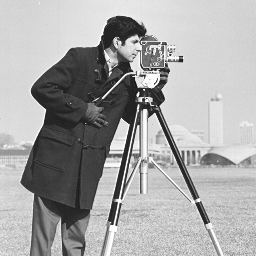

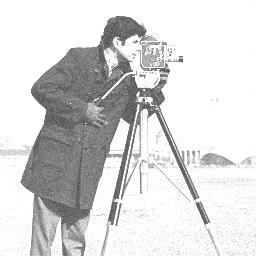

(256, 256)
(256, 256)
torch.Size([1, 256, 256, 256])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (65536x256 and 65536x32)

In [39]:
from PIL import Image
from google.colab.patches import cv2_imshow
import imageio.v2 as imageio

# Load the test image
test_image_path = "/content/test_image (1).tiff"
test_image = imageio.imread(test_image_path)
cv2_imshow(test_image)

# Convert the image to a numpy array
test_image_array = np.array(test_image) / 255.0  # Normalize pixel values to [0, 1]

# Add noise to the image
noisy_image = add_noise(test_image)
cv2_imshow(noisy_image)
# Denoise using DIP with Autoencoder

print(test_image.shape)
denoised_autoencoder = project_DIP(test_image, depth_vec_autoencoder, 'Autoencoder')
psnr_autoencoder = calculate_psnr(test_image_array, denoised_autoencoder)

# Denoise using DIP with ResNet
#denoised_resnet = project_DIP(noisy_image, depth_vec_resnet, 'ResNet')
#psnr_resnet = calculate_psnr(test_image_array, denoised_resnet)

# Denoise using DIP with GAN
#denoised_gan = project_DIP(noisy_image, depth_vec_gan, 'GAN')
#psnr_gan = calculate_psnr(test_image_array, denoised_gan)

print("PSNR for Autoencoder:", psnr_autoencoder)
print("PSNR for ResNet:", psnr_resnet)
print("PSNR for GAN:", psnr_gan)